In [61]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

*Note: We are assuming the Dataset Contains customer/marketing data as of 10/30/2014 (used enrollment date and recency from original table to come up with a reasonable estimation). Throughout the six campaigns, the offer is constant and we'll assume its a discount on a bundle of products including wine, meat, fish, sweets, and a small piece of gold jewelry. 

All of the customers included in the dataset were enrolled prior to the six marketing campaigns. Data does not account for any added customers during the six campaigns. (*Each customer was presented offer six times*) 

Amount spent on wine, meat, fish, sweets, and gold product is over the last two years. 

In [62]:
marketing = pd.read_csv('marketing_campaign.csv')
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
ID                     2240 non-null int64
Year_Birth             2240 non-null int64
Education              2240 non-null object
Relationship_Status    2240 non-null object
Income                 2216 non-null float64
Kids                   2240 non-null int64
Teens                  2240 non-null int64
Enroll_Date            2240 non-null object
Recency                2240 non-null int64
Wine ($)               2240 non-null int64
Fruit ($)              2240 non-null int64
Meat ($)               2240 non-null int64
Fish ($)               2240 non-null int64
Sweets ($)             2240 non-null int64
Gold_Products ($)      2240 non-null int64
Discount_Purchases     2240 non-null int64
Web_Purchases          2240 non-null int64
Catalog_Purchases      2240 non-null int64
Store_Purchases        2240 non-null int64
Complaint              2240 non-null int64
Campaign1              2240 

Missing income information for several customers, will utilize average income for their respective education and age.

Age column will be engineered from birth dates into different group values (Ex: 20 - 29, 30 - 39...)

In [63]:
## Checking for any mistaken customer duplicate entries ###
print(max(marketing.ID.value_counts()))

1


In [64]:
### Exploring birth years of customers ###
marketing['Year_Birth'].sort_values(ascending=True)

239     1893
339     1899
192     1900
1950    1940
424     1941
        ... 
747     1995
1850    1995
696     1995
1170    1996
46      1996
Name: Year_Birth, Length: 2240, dtype: int64

The three oldest customers above have most likely passed away, I will exclude them in this study 

In [65]:
marketing = marketing.drop(index=[239, 339, 192], axis=0)

Youngest Customer: 18 
Oldest Customer: 74
Age_Group
Forties       676
Thirties      557
Fifties       467
Sixties       300
Twenties      214
Seventies      16
Late-Teens      7
Name: Age_Group, dtype: int64

Most Customers are in their Forties


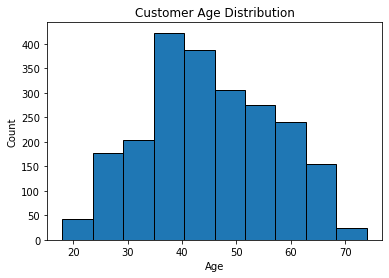

count    2237.000000
mean       45.098346
std        11.701917
min        18.000000
25%        37.000000
50%        44.000000
75%        55.000000
max        74.000000
Name: Age, dtype: float64


In [66]:
### Creating Age Groups (Do not know which month customers were born, we'll assume they were born after June 30th) ###
marketing['Age'] = 2014 - marketing['Year_Birth']
print('Youngest Customer:', min(marketing['Age']), '\nOldest Customer:', max(marketing['Age']))
marketing['Age_Group'] = ''
for idx, row in marketing.iterrows():
    if 18 <= row['Age'] < 20:
        marketing.loc[idx, 'Age_Group'] = 'Late-Teens'
    elif 20 <= row['Age'] < 30:
        marketing.loc[idx, 'Age_Group'] = 'Twenties'
    elif 30 <= row['Age'] < 40:
        marketing.loc[idx, 'Age_Group'] = 'Thirties'
    elif 40 <= row['Age'] < 50:
        marketing.loc[idx, 'Age_Group'] = 'Forties'
    elif 50 <= row['Age'] < 60:
        marketing.loc[idx, 'Age_Group'] = 'Fifties'
    elif 60 <= row['Age'] < 70:
        marketing.loc[idx, 'Age_Group'] = 'Sixties'
    elif 70 <= row['Age'] < 80:
        marketing.loc[idx, 'Age_Group'] = 'Seventies'
marketing = marketing.drop(['Year_Birth'], axis=1)
marketing = marketing[['ID', 'Age', 'Age_Group', 'Education', 'Relationship_Status', 'Income', 'Kids', 'Teens', 'Enroll_Date', 'Recency', 'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Campaign1', 'Campaign2', 'Campaign3', 'Campaign4', 'Campaign5', 'Campaign6', 'Complaint']]
print(marketing.groupby('Age_Group')['Age_Group'].count().sort_values(ascending=False))
print('\nMost Customers are in their Forties')
plt.hist(marketing['Age'], edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Customer Age Distribution')
plt.show()
print(marketing['Age'].describe())

In [67]:
### Simplifying Relationship status ###
for idx, row in marketing.iterrows():
    if row['Relationship_Status'] == 'YOLO' or row['Relationship_Status'] == 'Alone' or row['Relationship_Status'] == 'Absurd':
        marketing.loc[idx, 'Relationship_Status'] = 'Single'
    elif row['Relationship_Status'] == 'Together':
        marketing.loc[idx, 'Relationship_Status'] = 'In-Relationship'
print(marketing.groupby('Relationship_Status')['Relationship_Status'].count().sort_values(ascending=False))


Relationship_Status
Married            864
In-Relationship    579
Single             486
Divorced           231
Widow               77
Name: Relationship_Status, dtype: int64


count      2237.000000
mean      52239.753759
std       25046.050354
min        1730.000000
25%       35523.000000
50%       51390.000000
75%       68281.000000
max      666666.000000
Name: Income, dtype: float64

^^^Max Income of 666666.0 is 4.105162041170711 greater than the second highest income of 162397.0

This one very wealthy individual is skewing our distribution and descriptive statistics. While it may be possible that one of the countrys wealthiest individuals shops at this store, I chose to exclude he/she from this analysis as they did not respond to any of the 6 campaigns for the offer


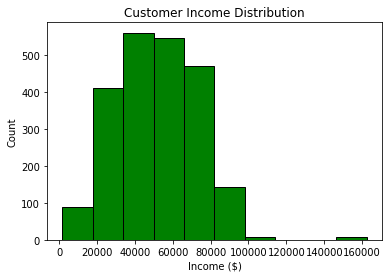

count      2236.000000
mean      51964.965635
std       21414.882468
min        1730.000000
25%       35502.500000
50%       51381.500000
75%       68275.750000
max      162397.000000
Name: Income, dtype: float64


In [68]:
### Imputing missing Income values based on education & age group ###
import matplotlib.pyplot as plt

marketing = marketing.fillna(0)
for idx, row in marketing.iterrows():
    if row['Income'] == 0:
        education = row['Education']
        age_group = row['Age_Group']
        df = marketing.loc[(marketing['Education'] == education) & (marketing['Age_Group'] == age_group)]
        marketing.loc[idx, 'Income'] = np.mean(df['Income'])
print(marketing['Income'].describe())
income = sorted(list(marketing['Income'].values))
print('\n^^^Max Income of', max(income), 'is', max(income)/income[-2], 'greater than the second highest income of', income[-2])
print('\nThis one very wealthy individual is skewing our distribution and descriptive statistics. While it may be possible that one of the countrys wealthiest individuals shops at this store, I chose to exclude he/she from this analysis as they did not respond to any of the 6 campaigns for the offer')
marketing = marketing.loc[~(marketing['Income'] == 666666)]
plt.hist(marketing['Income'], edgecolor='black', color='green')
plt.title('Customer Income Distribution')
plt.xlabel('Income ($)')
plt.ylabel('Count')
plt.show()
print(marketing['Income'].describe())

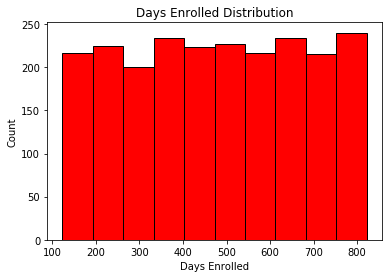

count    2232.000000
mean      476.651882
std       202.214846
min       123.000000
25%       303.750000
50%       478.500000
75%       652.000000
max       822.000000
Name: Days_Enrolled, dtype: float64 

Customer acquisition rate has been relatively steady. (very slight decline over time, but nothing overly concerning)


In [69]:
### Using Enrollment Date to get idea of how long customers have been enrolled with the store ###
from datetime import datetime

date1 = datetime.strptime('2014-10-30', "%Y-%m-%d").date()
marketing['Enroll_Date'] = pd.to_datetime(marketing['Enroll_Date']).dt.date

def numOfDays(date1, date2): 
    return abs(date2-date1).days

num_of_days = []
for value in list(marketing['Enroll_Date'].values):
    days = numOfDays(date1, value)
    num_of_days.append(days)
    
marketing['Days_Enrolled'] = pd.Series([int(d) for d in num_of_days])
plt.hist(marketing['Days_Enrolled'], edgecolor='black', color='red')
plt.xlabel('Days Enrolled')
plt.ylabel('Count')
plt.title('Days Enrolled Distribution')
plt.show()
print(marketing['Days_Enrolled'].describe(), '\n\nCustomer acquisition rate has been relatively steady. (very slight decline over time, but nothing overly concerning)')

In [70]:
### Engineering some more features: Average Purchase Frequency and Average Spend on a Purchase ###
marketing['Total Spent ($)'] = marketing['Wine ($)'] + marketing['Fruit ($)'] + marketing['Meat ($)'] + marketing['Fish ($)'] + marketing['Sweets ($)'] + marketing['Gold_Products ($)']
marketing['Number_Purchases'] = marketing['Discount_Purchases'] + marketing['Web_Purchases'] + marketing['Catalog_Purchases'] + marketing['Store_Purchases']
marketing['Avg_Purch_Freq'] = (marketing['Days_Enrolled'] / marketing['Number_Purchases']).replace(np.inf, np.nan)
marketing['Avg_Spend ($)'] = (marketing['Total Spent ($)'] / marketing['Number_Purchases']).replace(np.inf, np.nan)

Upon examining the average spend data, the max average spend was 1,679 on one single purchase for a customer who had enrolled in 2012. The next highest average spend is 187, so I'm choosing to beleive this customer will not return and we can exclude them from analysis. Customers who have never made a single purchase were also excluded. In total this was just 5 customers that were excluded. 

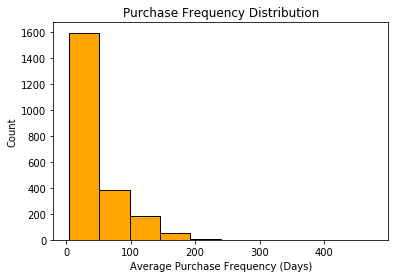

count    2227.000000
mean       45.586903
std        39.255510
min         3.968750
25%        20.220648
50%        31.863636
75%        58.476190
max       476.000000
Name: Avg_Purch_Freq, dtype: float64


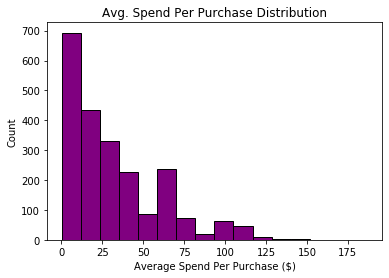

count    2227.000000
mean       32.584545
std        28.525089
min         0.533333
25%         9.714286
50%        23.384615
75%        45.281773
max       186.500000
Name: Avg_Spend ($), dtype: float64


In [71]:
marketing = marketing.loc[~((marketing['Avg_Spend ($)'] == 1679) | (marketing['Avg_Spend ($)'].isnull()) | (marketing['Avg_Purch_Freq'].isnull()))]
plt.hist(marketing['Avg_Purch_Freq'], bins=10, edgecolor='black', color='orange')
plt.ylabel('Count')
plt.xlabel('Average Purchase Frequency (Days)')
plt.title('Purchase Frequency Distribution')
plt.show()
print(marketing['Avg_Purch_Freq'].describe())
plt.hist(marketing['Avg_Spend ($)'], bins=16, edgecolor='black', color='purple')
plt.ylabel('Count')
plt.xlabel('Average Spend Per Purchase ($)')
plt.title('Avg. Spend Per Purchase Distribution')
plt.show()
print(marketing['Avg_Spend ($)'].describe())

In [72]:
### Adding Acceptance (%) for each customer after the six campaigns ###
campaigns = ['Campaign1', 'Campaign2', 'Campaign3', 'Campaign4', 'Campaign5', 'Campaign6']
marketing['Cust_Accept (%)'] = 0
marketing['Accept_One'] = 0
for idx, row in marketing.iterrows():
    acceptance_count = 0
    for campaign in campaigns:
        if row[campaign] == 1:
            acceptance_count += 1
    if acceptance_count > 0:
        marketing.loc[idx, 'Accept_One'] = 1
    acceptance_rate = (acceptance_count / 6) * 100
    marketing.loc[idx, 'Cust_Accept (%)'] = acceptance_rate
print(marketing['Cust_Accept (%)'].describe())
num_acc = sum(marketing['Accept_One'])
print('\nValue Counts (%)\n', marketing['Cust_Accept (%)'].value_counts())
print('\n', num_acc, 'customers accepted the offer at least once during the six campaigns')

sum_accepted = 0
total_attempts = 6 * len(marketing)
for campaign in campaigns:
    sum_accepted += sum(marketing[campaign])
overall = sum_accepted / total_attempts * 100
print('\nThe offer was accepted', sum_accepted, 'times out of', total_attempts, 'attempts for an overall acceptance percentage of', str(round(overall, 2)) + '% and an overall loss of', (sum_accepted * 22) - (total_attempts * 2))

count    2227.000000
mean        7.453974
std        14.872551
min         0.000000
25%         0.000000
50%         0.000000
75%        16.666667
max        83.333333
Name: Cust_Accept (%), dtype: float64

Value Counts (%)
 0.000000     1623
16.666667     365
33.333333     142
50.000000      51
66.666667      36
83.333333      10
Name: Cust_Accept (%), dtype: int64

 604 customers accepted the offer at least once during the six campaigns

The offer was accepted 996 times out of 13362 attempts for an overall acceptance percentage of 7.45% and an overall loss of -4812


In [73]:
print(1623/2227)

0.7287831162999551


  Age_Group  Accept_One %  Total Customers
  Seventies     56.250000               16
 Late-Teens     42.857143                7
    Fifties     29.399142              466
    Sixties     28.282828              297
    Forties     26.557864              674
   Twenties     25.700935              214
   Thirties     24.773960              553


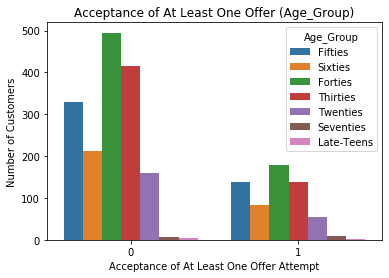

In [74]:
import seaborn as sns
import collections

ax = sns.countplot('Accept_One', hue='Age_Group', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Age_Group)')

dict_percent = collections.defaultdict(list)
for category in list(marketing['Age_Group'].unique()):
    dict_percent['Age_Group'].append(category)
    total = len(marketing.loc[marketing['Age_Group'] == category])
    accept = len(marketing.loc[(marketing['Age_Group'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['Total Customers'].append(total)

df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One %', ascending=False)
print(df_percents.to_string(index=False))



  Education  Accept_One %  Total Customers
        PhD     32.157676              482
     Master     27.100271              369
 Graduation     26.470588             1122
   2n Cycle     22.500000              200
      Basic     12.962963               54


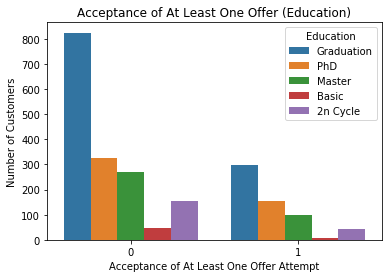

In [75]:
ax = sns.countplot('Accept_One', hue='Education', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Education)')

dict_percent = collections.defaultdict(list)
for category in list(marketing['Education'].unique()):
    dict_percent['Education'].append(category)
    total = len(marketing.loc[marketing['Education'] == category])
    accept = len(marketing.loc[(marketing['Education'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['Total Customers'].append(total)

df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One %', ascending=False)
print(df_percents.to_string(index=False))


Relationship_Status  Accept_One %  Total Customers
              Widow     35.064935               77
             Single     31.134021              485
           Divorced     29.824561              228
            Married     25.058005              862
    In-Relationship     24.695652              575


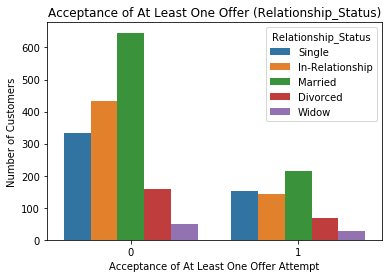

In [76]:
ax = sns.countplot('Accept_One', hue='Relationship_Status', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Relationship_Status)')

dict_percent = collections.defaultdict(list)
for category in list(marketing['Relationship_Status'].unique()):
    dict_percent['Relationship_Status'].append(category)
    total = len(marketing.loc[marketing['Relationship_Status'] == category])
    accept = len(marketing.loc[(marketing['Relationship_Status'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['Total Customers'].append(total)

df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One %', ascending=False)
print(df_percents.to_string(index=False))

count    2227.000000
mean        0.951504
std         0.750789
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Children, dtype: float64


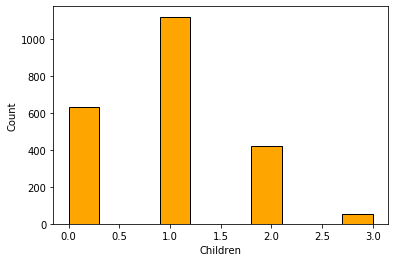

 Children  Accept_One %  Total Customers
        0     44.620253              632
        1     21.015138             1123
        2     19.047619              420
        3     11.538462               52


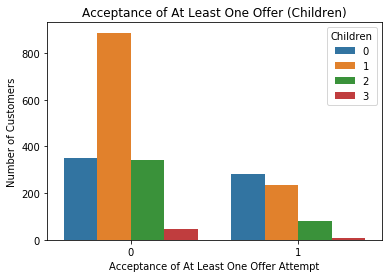

'The offer was very popular with those that do not have any children. This compliments what we saw earlier in single adults having a respectable acceptance percentage to the offer'

In [77]:
### Simplifying Kids and Teens columns into one 'Children' column ###

marketing['Children'] = 0
for idx, row in marketing.iterrows():
    marketing.loc[idx, 'Children'] = row['Kids'] + row['Teens']
print(marketing['Children'].describe())

plt.hist(marketing['Children'], edgecolor='black', color='orange')
plt.ylabel('Count')
plt.xlabel('Children')
plt.show()

dict_percent = collections.defaultdict(list)
for category in list(marketing['Children'].unique()):
    dict_percent['Children'].append(category)
    total = len(marketing.loc[marketing['Children'] == category])
    accept = len(marketing.loc[(marketing['Children'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One %', ascending=False)
print(df_percents.to_string(index=False))

ax = sns.countplot('Accept_One', hue='Children', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Children)')
plt.show()

'The offer was very popular with those that do not have any children. This compliments what we saw earlier in single adults having a respectable acceptance percentage to the offer'


       Product  Total Customer Spend ($)  Product %
          Wine                    678164  50.212723
         Fruit                     58666   4.343757
          Meat                    371241  27.487483
          Fish                     83802   6.204881
        Sweets                     60503   4.479772
 Gold_Products                     98206   7.271384


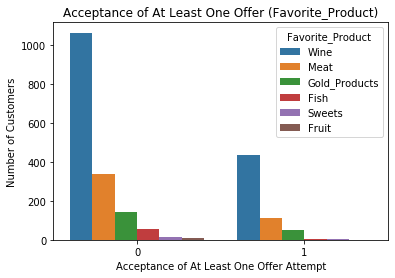

Favorite_Product  Accept_One %  Total Customers
            Wine     29.086057             1499
   Gold_Products     25.257732              194
            Meat     24.888889              450
          Sweets     23.529412               17
           Fruit      9.090909               11
            Fish      3.571429               56


'The acceptance was very poor among customers who spend most of their money on fish products'

In [78]:
### Analyzing total customer spend by product ###
dict_products = collections.defaultdict(list)
total_cust_spend = sum(marketing['Wine ($)']) + sum(marketing['Fruit ($)']) + sum(marketing['Meat ($)']) + sum(marketing['Fish ($)']) + sum(marketing['Sweets ($)']) + sum(marketing['Gold_Products ($)'])
for product in ['Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)']:
    dict_products['Product'].append(product[:-4])
    prod_spend = sum(marketing[product])
    dict_products['Total Customer Spend ($)'].append(prod_spend)
    percent_spend = (prod_spend / total_cust_spend) * 100
    dict_products['Product %'].append(percent_spend)
df_products = pd.DataFrame(dict_products)
print(df_products.to_string(index=False))

### Classifying Customers Based on what product they spend the most money on ###
marketing['Favorite_Product'] = ''
for idx, row in marketing.iterrows():
    cust_spend = []
    for product in ['Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)']:
        cust_spend.append(row[product])
    most_spend = max(cust_spend)
    for product_name in ['Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)']: 
        if row[product_name] == most_spend:
            marketing.loc[idx, 'Favorite_Product'] = product_name[:-4]

ax = sns.countplot('Accept_One', hue='Favorite_Product', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Favorite_Product)')
plt.show()
            
dict_percent = collections.defaultdict(list)
for category in list(marketing['Favorite_Product'].unique()):
    dict_percent['Favorite_Product'].append(category)
    total = len(marketing.loc[marketing['Favorite_Product'] == category])
    accept = len(marketing.loc[(marketing['Favorite_Product'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One %', ascending=False)
print(df_percents.to_string(index=False))
'The acceptance was very poor among customers who spend most of their money on fish products'

Purchase Channel  Total # of Purchases  Channel %
        Discount                  5188  15.636397
             Web                  9121  27.490280
         Catalog                  5944  17.914946
           Store                 12926  38.958377


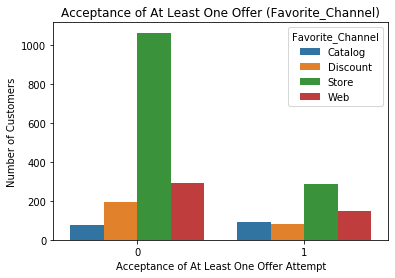

Favorite_Channel  Accept_One %  Total Customers
         Catalog     55.029586              169
             Web     33.638444              437
        Discount     28.832117              274
           Store     21.158129             1347


'Here we see that the offer is very succesful among those who make most of their purchases via catalog. More than half of them accepted the offer which is very encouraging.'

In [79]:
### Analyzing total purchase count by purchase channel ###
dict_channels = collections.defaultdict(list)
total_num_purchases = sum(marketing['Discount_Purchases']) + sum(marketing['Web_Purchases']) + sum(marketing['Catalog_Purchases']) + sum(marketing['Store_Purchases'])
for channel in ['Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases']:
    dict_channels['Purchase Channel'].append(channel[:-10])
    num_purchases = sum(marketing[channel])
    dict_channels['Total # of Purchases'].append(num_purchases)
    percent_purchases = (num_purchases / total_num_purchases) * 100
    dict_channels['Channel %'].append(percent_purchases)
df_products = pd.DataFrame(dict_channels)
print(df_products.to_string(index=False))

## Classifying Customers Based on what purchase channel they utilized most ###
marketing['Favorite_Channel'] = ''
for idx, row in marketing.iterrows():
    cust_purchase_counts = []
    for channel in ['Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases']:
        cust_purchase_counts.append(row[channel])
    most_purchases = max(cust_purchase_counts)
    # Allowing the tie breaker to go to channels that had the lowest channel % of purchases among all the customers #
    for channel_name in ['Store_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Discount_Purchases']: 
        if row[channel_name] == most_purchases:
            marketing.loc[idx, 'Favorite_Channel'] = channel_name[:-10]

ax = sns.countplot('Accept_One', hue='Favorite_Channel', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Favorite_Channel)')
plt.show()
            
dict_percent = collections.defaultdict(list)
for category in list(marketing['Favorite_Channel'].unique()):
    dict_percent['Favorite_Channel'].append(category)
    total = len(marketing.loc[marketing['Favorite_Channel'] == category])
    accept = len(marketing.loc[(marketing['Favorite_Channel'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One %', ascending=False)
print(df_percents.to_string(index=False))
'Here we see that the offer is very succesful among those who make most of their purchases via catalog. More than half of them accepted the offer which is very encouraging.'

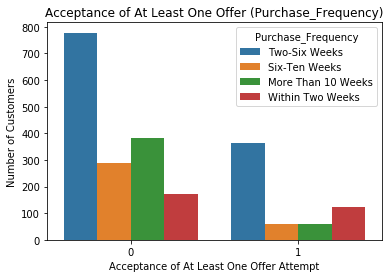

 Purchase_Frequency  Accept_One %  Total Customers
   Within Two Weeks     41.554054              296
      Two-Six Weeks     31.754386             1140
      Six-Ten Weeks     16.905444              349
 More Than 10 Weeks     13.574661              442

The offer is increasingly more popular with those who purchase products from the company more frequently 

 74.14% of customers average a product purchase within every six weeks


In [80]:
### Analyzing Acceptance based on a how often a customer makes a purchase ###
marketing['Purchase_Frequency'] = ''
for idx, row in marketing.iterrows():
    if 0 < row['Avg_Purch_Freq'] < 14:
        marketing.loc[idx, 'Purchase_Frequency'] = 'Within Two Weeks'
    elif 14 <= row['Avg_Purch_Freq'] < 42:
        marketing.loc[idx, 'Purchase_Frequency'] = 'Two-Six Weeks'
    elif 42 <= row['Avg_Purch_Freq'] < 70:
        marketing.loc[idx, 'Purchase_Frequency'] = 'Six-Ten Weeks'
    else:
        marketing.loc[idx, 'Purchase_Frequency'] = 'More Than 10 Weeks'

ax = sns.countplot('Accept_One', hue='Purchase_Frequency', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Purchase_Frequency)')
plt.show()
            
dict_percent = collections.defaultdict(list)
for category in list(marketing['Purchase_Frequency'].unique()):
    dict_percent['Purchase_Frequency'].append(category)
    total = len(marketing.loc[marketing['Purchase_Frequency'] == category])
    accept = len(marketing.loc[(marketing['Purchase_Frequency'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One %', ascending=False)
print(df_percents.to_string(index=False))
print('\nThe offer is increasingly more popular with those who purchase products from the company more frequently', '\n\n', str(round((((1013 + 638) / 2227) * 100), 2)) + '% of customers average a product purchase within every six weeks')

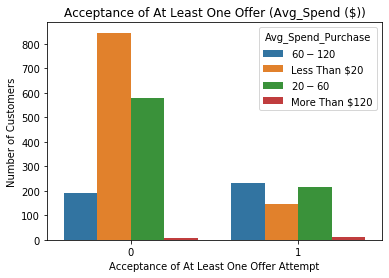

  Avg_Spend ($)  Accept_One %  Total Customers
 More Than $120     64.705882               17
     $60 - $120     54.739336              422
      $20 - $60     27.135678              796
  Less Than $20     14.717742              992


'The offer is increasingly more popular among those who spend more per purchase. These customers favor buying in bulk as their goal is to save some money. When you present an offer to further save money to these customers on their bulk purchase, its reasonable to assume they will be more likely to accept the offer'

In [81]:
### Analyzing Acceptance based on a customer's average spend per purchase ###

marketing['Avg_Spend_Purchase'] = ''
for idx, row in marketing.iterrows():
    if 0 < row['Avg_Spend ($)'] < 20:
        marketing.loc[idx, 'Avg_Spend_Purchase'] = 'Less Than $20'
    elif 20 <= row['Avg_Spend ($)'] < 60:
        marketing.loc[idx, 'Avg_Spend_Purchase'] = '$20 - $60'
    elif 60 <= row['Avg_Spend ($)'] < 120:
        marketing.loc[idx, 'Avg_Spend_Purchase'] = '$60 - $120'
    else:
        marketing.loc[idx, 'Avg_Spend_Purchase'] = 'More Than $120'

ax = sns.countplot('Accept_One', hue='Avg_Spend_Purchase', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Avg_Spend ($))')
plt.show()
            
dict_percent = collections.defaultdict(list)
for category in list(marketing['Avg_Spend_Purchase'].unique()):
    dict_percent['Avg_Spend ($)'].append(category)
    total = len(marketing.loc[marketing['Avg_Spend_Purchase'] == category])
    accept = len(marketing.loc[(marketing['Avg_Spend_Purchase'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One %', ascending=False)
print(df_percents.to_string(index=False))
'The offer is increasingly more popular among those who spend more per purchase. These customers favor buying in bulk as their goal is to save some money. When you present an offer to further save money to these customers on their bulk purchase, its reasonable to assume they will be more likely to accept the offer'

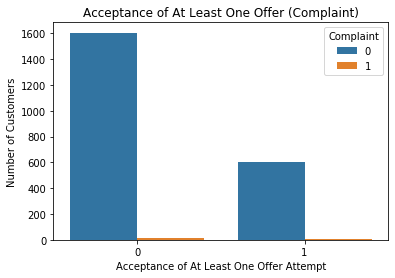

 Complaint  Accept_One %  Total Customers
         0     27.231536             2207
         1     15.000000               20


'We cant say that complaints is a significant factor in whether the customer will accept offer or not from the above figures. Only 20 customers filed a complaint in the last 2 years, leading to severe oversampling in those who did not complain when approaching Machine Learning modeling. Complaint is among several features I will drop below'

In [82]:
### Seeing if customer complaints affected acceptance ###

ax = sns.countplot('Accept_One', hue='Complaint', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Complaint)')
plt.show()
dict_percent = collections.defaultdict(list)

for category in list(marketing['Complaint'].unique()):
    dict_percent['Complaint'].append(category)
    total = len(marketing.loc[marketing['Complaint'] == category])
    accept = len(marketing.loc[(marketing['Complaint'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent)
print(df_percents.to_string(index=False))
'We cant say that complaints is a significant factor in whether the customer will accept offer or not from the above figures. Only 20 customers filed a complaint in the last 2 years, leading to severe oversampling in those who did not complain when approaching Machine Learning modeling. Complaint is among several features I will drop below'

In [83]:
### Dropping unnecessary features / features used to engineer others ###
marketing = marketing.drop(['ID', 'Age_Group', 'Recency', 'Kids', 'Teens', 'Enroll_Date', 'Campaign1', 'Campaign2', 'Campaign3', 'Campaign4', 'Campaign5', 'Campaign6', 'Number_Purchases', 'Favorite_Product', 'Favorite_Channel', 'Purchase_Frequency', 'Avg_Spend_Purchase', 'Complaint'], axis=1)
marketing = marketing[['Age', 'Education', 'Relationship_Status', 'Income', 'Children', 'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled', 'Avg_Purch_Freq', 'Avg_Spend ($)','Accept_One', 'Cust_Accept (%)']]

for idx, row in marketing.iterrows():
    if row['Cust_Accept (%)'] == 0:
            marketing.loc[idx, 'Accept_Rate'] = '(0/6)'
    elif row['Cust_Accept (%)'] == ((1/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(1/6)'
    elif row['Cust_Accept (%)'] == ((2/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(2/6)'
    elif row['Cust_Accept (%)'] == ((3/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(3/6)'
    elif row['Cust_Accept (%)'] == ((4/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(4/6)'
    elif row['Cust_Accept (%)'] == ((5/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(5/6)'

marketing = marketing[['Age', 'Education', 'Relationship_Status', 'Income', 'Children', 'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled', 'Avg_Purch_Freq', 'Avg_Spend ($)','Accept_One', 'Accept_Rate', 'Cust_Accept (%)']]

### Obtaining DF to be utilized in Machine Learning Notebook ###
marketing.to_csv('Cust_Records.csv', index=False)

In [84]:
print('Accept_Rate Value Counts')
print(marketing['Accept_Rate'].value_counts())

Accept_Rate Value Counts
(0/6)    1623
(1/6)     365
(2/6)     142
(3/6)      51
(4/6)      36
(5/6)      10
Name: Accept_Rate, dtype: int64


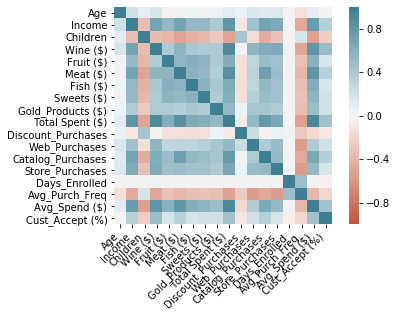

In [85]:
### Correlation Heatmap ###

numerical = marketing.drop(['Education', 'Relationship_Status', 'Accept_One'], axis=1)
corr = numerical.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

From above figure, I'd say that Income, Amount of money spend on wine products ("Wine ($)"), number of catalog purchases, and the average amount of money a customer spends per purchase are the greatest drivers of increasing a customers offer acceptance percentage. All of these features contained positive correlation with eachother. 

The number of children a customer has decreased correlation across the board for the most part. Only the number of discount purchases, age, and average purchase frequency contained positive correlation, which all make some sense. Average purchases frequency also contained negative correlation with many of the features.   